<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/1.Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
import cv2
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
import csv

In [173]:
import os
from google.colab import files
files.upload()
!pip install kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_p

In [174]:
from os import listdir

base_path = "../content/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [175]:
healthy_patch =  "../content/healthy_patch"
cancer_patch =  "../content/cancer_patch"
!mkdir healthy_patch
!mkdir cancer_patch

mkdir: cannot create directory ‘healthy_patch’: File exists
mkdir: cannot create directory ‘cancer_patch’: File exists


#I count how many patches for each class I have and how many I have in total

In [176]:
import shutil

first = True
check_dim = True
for patches_each_patient in folder:
  path_patient = base_path +"/"+ patches_each_patient  #"../content/IDC_regular_ps50_idx5/id_patient"
  classes = listdir(path_patient)
  for c in classes:
    path_patient_class = path_patient +"/"+ c   #"../content/IDC_regular_ps50_idx5/id_patient/class0-1"
    for patch in listdir(path_patient_class):
      path_patient_patch = path_patient_class + "/" + patch
      if c == "0":
        shutil.copy(path_patient_patch, healthy_patch)
      elif c == "1":
        shutil.copy(path_patient_patch, cancer_patch)
      if first == False:
        if img.shape != mpimg.imread(path_patient_patch).shape:
          check_dim = False
total_cancer_patches = listdir(cancer_patch)
total_healthy_patches = listdir(healthy_patch)
total_patches = total_cancer_patches + total_healthy_patches

print("Number of cancer patches: " + str(len(total_cancer_patches)))
print("Number of healthy patches: " + str(len(total_healthy_patches))) 
print("Totla number patches: "+ str(len(total_patches)))

print("All image have same size: "+ str(check_dim))

Number of cancer patches: 78786
Number of healthy patches: 198738
Totla number patches: 277524
All image have same size: True


In [177]:
print("Number of cancer patches: " + str(len(total_cancer_patches)))
print("Number of healthy patches: " + str(len(total_healthy_patches))) 
print("Totla number patches: "+ str(len(total_patches)))

Number of cancer patches: 78786
Number of healthy patches: 198738
Totla number patches: 277524


#Split the dataset

In [178]:
def split_dataset(dataset, dataset_size, train_percentage=0.6, val_percentage=0.2, test_percentage=0.2, shuffle=True):
  """
    split_dataset splits the dataset into training, validation and test sets.

    :param dataset: a list representing the whole dataset
    :param dataset_size: number of elements in the dataset
    :param train_percentage: the percentage of the dataset that will be used for training
    :param val_percentage: the percentage of the dataset that will be used for validation
    :param test_percentage: the percentage of the dataset that will be used for testing
    :param shuffle: if True the elements of the dataset will be randomly shuffled
    :return: three lists representing the training, validation and test sets
  """
  if train_percentage + val_percentage + test_percentage != 1:
    print('Total of percentages must be 1')
    return None, None, None
  
  if shuffle:
    random.shuffle(dataset)
    
  train_size = int(train_percentage * dataset_size)
  val_size = int(val_percentage * dataset_size)

  train_set = dataset[0:train_size]
  val_set = dataset[train_size:train_size+val_size]
  test_set = dataset[train_size+val_size:dataset_size]
    
  return train_set, val_set, test_set

In [179]:
random.seed(24) # seed is specified to always obtain the same results
training_set, validation_set, test_set = split_dataset(total_patches, len(total_patches))

num_training_samples = len(training_set)
num_validation_samples = len(validation_set)
num_test_samples = len(test_set)

print("Number of samples in the training set: " + str(num_training_samples))
print("Number of samples in the validation set: " + str(num_validation_samples))
print("Number of samples in the test set: " + str(num_test_samples))

Number of samples in the training set: 166514
Number of samples in the validation set: 55504
Number of samples in the test set: 55506


# Solving the Unbalanced Classes Issue
As we can see from the histogram below, the number of images for the two classes is not the same. 

Number of healthy patches: 119207
Number of cancer images: 47307
True


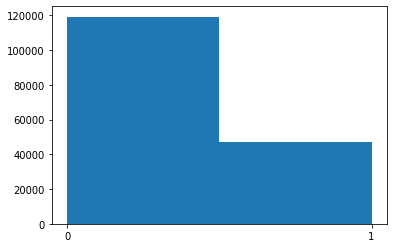

In [180]:
healthy_samples = [entry for entry in training_set if entry.split("_")[4][5] == '0']
cancer_samples = [entry for entry in training_set if entry.split("_")[4][5] == '1']

labels = [entry.split("_")[4][5] for entry in training_set]
_ = plt.hist(labels, bins=2)


print("Number of healthy patches: " + str(len(healthy_samples)))
print("Number of cancer images: " + str(len(cancer_samples)))
print((len(healthy_samples)+len(cancer_samples))==num_training_samples)

**We want the classes to have the same number of images, so we need to balance everything**


In [181]:
expected_samples_per_class = num_training_samples//2
print("Number of expected images per class: " + str(expected_samples_per_class))
print("Number of cancer cell images: " + str(len(healthy_samples)))

Number of expected images per class: 83257
Number of cancer cell images: 119207


For the class containing multiple samples we will do a subsampling

In [182]:
healthy_samples = random.sample(healthy_samples, expected_samples_per_class)
print("Number of sampled healthy patches: " + str(len(healthy_samples)))

Number of sampled healthy patches: 83257


**For the class containing fewer samples we will oversample**

In [183]:
cancer_samples_needed = expected_samples_per_class - len(cancer_samples)
new_cancer_samples = random.sample(cancer_samples, cancer_samples_needed)
cancer_samples= cancer_samples + new_cancer_samples
training_set = cancer_samples + healthy_samples
print("Number of sampled normal cell images to perform augmentation: " + str(len(new_cancer_samples)))
print("Final number of normal cell images: " + str(len(cancer_samples)))

Number of sampled normal cell images to perform augmentation: 35950
Final number of normal cell images: 83257


**Balanced training**

Number of healthy patches: 83257
Number of cancer images: 83257


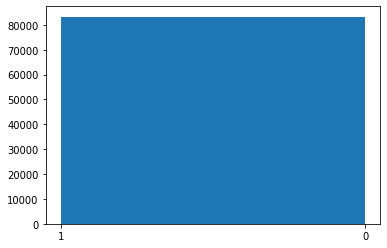

In [184]:
healthy_samples = [entry for entry in training_set if entry.split("_")[4][5] == '0']
cancer_samples = [entry for entry in training_set if entry.split("_")[4][5] == '1']

labels = [entry.split("_")[4][5] for entry in training_set]
_ = plt.hist(labels, bins=2)


print("Number of healthy patches: " + str(len(healthy_samples)))
print("Number of cancer images: " + str(len(cancer_samples)))

#Normalization function

Text(0.5, 1.0, ' mean and divided by standard devetion')

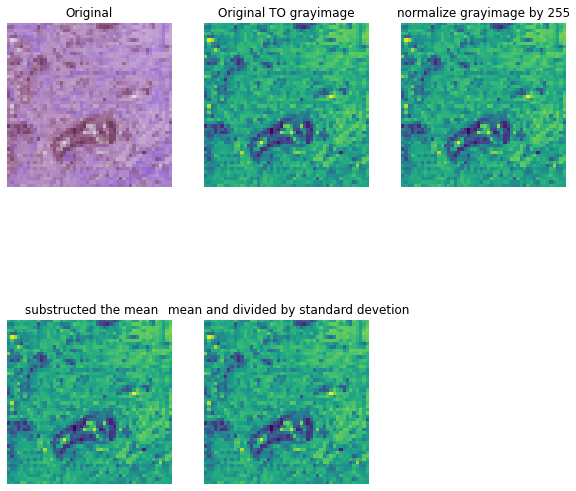

In [185]:
import cv2
original_image = cv2.imread(cancer_patch + "/14210_idx5_x1601_y1451_class1.png")

def normailization(original_image):
  img = original_image
  #print(f"Before turning to grayscale: {img.shape}")
  #rgb  to  gray image
  gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #print(f"After turning to grayscale: {gray_image.shape}")
  #nomalize
  norm_image = gray_image/255
  #mean and standard
  (mean, stddev) = cv2.meanStdDev(norm_image)
  sub_mean = (norm_image - mean)
  #print(f"media immagine: {mean} Image with subtracted mean: {sub_mean}")
  div_sdv =(norm_image - mean) /stddev
  #print(f"standard devetion immagine: {stddev} Image with subtracted mean and divided with standard devetion: {norm_image - mean}")
  

  # Normalizzazione dell'immagine
  
  return gray_image,norm_image,sub_mean,div_sdv


fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original")

gray_image,norm_image,sub_mean,div_sdv= normailization(original_image)

fig.add_subplot(2, 3, 2)
plt.imshow(gray_image)
plt.axis('off')
plt.title("Original TO grayimage")

fig.add_subplot(2, 3, 3)
plt.imshow(norm_image)
plt.axis('off')
plt.title("normalize grayimage by 255")

fig.add_subplot(2, 3, 4)
plt.imshow(sub_mean)
plt.axis('off')
plt.title(" substructed the mean")

fig.add_subplot(2, 3, 5)
plt.imshow(sub_mean)
plt.axis('off')
plt.title(" mean and divided by standard devetion")




#Augmentations function

In [186]:
original_image = cv2.imread(cancer_patch + "/14210_idx5_x1601_y1451_class1.png")

def vertical_flip(original_image):
  return tf.image.flip_up_down(original_image)

def horizontal_flip(original_image):
  return tf.image.flip_left_right(original_image)

def rotation_90(original_image):
  return tf.image.rot90(original_image, k=1)

def rotation_180(original_image):
  return tf.image.rot90(original_image, k=2)

def rotation_270(original_image):
  return tf.image.rot90(original_image, k=3)

def itself(original_image):
  return original_image

augmentations = [
    itself,
    vertical_flip,
    horizontal_flip,
    rotation_90,
    rotation_180,
    rotation_270
]

def random_augmentation(original_image):
    random_function = random.choice(augmentations)
    augmented_image = random_function(original_image)
    return np.asarray(augmented_image)

**Example of rotation**

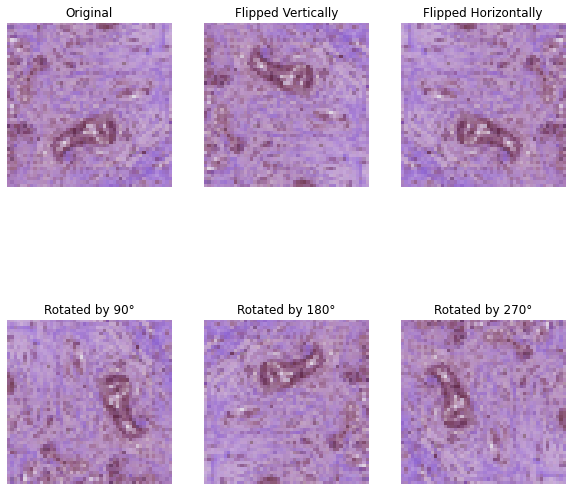

In [187]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original")

fig.add_subplot(2, 3, 2)
plt.imshow(vertical_flip(original_image))
plt.axis('off')
plt.title("Flipped Vertically")

fig.add_subplot(2, 3, 3)
plt.imshow(horizontal_flip(original_image))
plt.axis('off')
plt.title("Flipped Horizontally")

fig.add_subplot(2, 3, 4)
plt.imshow(rotation_90(original_image))
plt.axis('off')
plt.title("Rotated by 90°")

fig.add_subplot(2, 3, 5)
plt.imshow(rotation_180(original_image))
plt.axis('off')
plt.title("Rotated by 180°")

fig.add_subplot(2, 3, 6)
plt.imshow(rotation_270(original_image))
plt.axis('off')
_ = plt.title("Rotated by 270°")

#Ran augmentation function and transfer splitted dataset in more files


The folder tree is created, in the following order:

* train_test_validation
  *   Traning
    *   Healthy
    *   Cancer
  *   Validation
    *   Healthy
    *   Cancer
  *   Test
    *   Healthy
    *   Cancer







In [ ]:
# remove the old folder 'SplittedDataset'
#shutil.rmtree(healthy_patch, ignore_errors=True)
#shutil.rmtree(cancer_patch, ignore_errors=True)

#new path
train_test_validation_path =  "../content/train_test_validation"
training_path = train_test_validation_path + "/training"
validation_path = train_test_validation_path + "/validation"
test_path = train_test_validation_path + "/test"

# create the structure
os.makedirs(train_test_validation_path)
os.makedirs(training_path)
os.makedirs(validation_path)
os.makedirs(test_path)
os.makedirs(training_path + "/healthy")
os.makedirs(validation_path + "/healthy")
os.makedirs(test_path + "/healthy")
os.makedirs(training_path + "/cancer")
os.makedirs(validation_path + "/cancer")
os.makedirs(test_path + "/cancer")

**Traininig**


We apply augmentation only to training to bring more random variations to the images, some cloned.

In [ ]:
for i, (healthy, cancer) in enumerate(zip(healthy_samples, cancer_samples)):
  healthy_imge= cv2.imread(healthy_patch+"/"+healthy)
  new_healthy_imge= random_augmentation(healthy_imge)
  _,_,_,new_healthy_imge = normailization(new_healthy_imge)
  cv2.imwrite(training_path + "/healthy/"+str(i)+".png", new_healthy_imge)

  cancer_image= cv2.imread(cancer_patch+"/"+cancer)
  new_cancer_imge= random_augmentation(cancer_image)
  _,_,_,new_cancer_imge = normailization(new_cancer_imge)
  cv2.imwrite(training_path + "/cancer/"+str(i)+".png", new_cancer_imge)

print(f"file {i+1} moved")
 

Validation

In [ ]:
healthy_samples = [entry for entry in validation_set if entry.split("_")[4][5] == '0']
cancer_samples = [entry for entry in validation_set if entry.split("_")[4][5] == '1']

for i, healthy in enumerate(healthy_samples):
  healthy_imge= cv2.imread(healthy_patch+"/"+healthy)
  _,_,_,healthy_imge = normailization(healthy_imge)
  cv2.imwrite(validation_path + "/healthy/"+str(i)+".png", healthy_imge)

for j, cancer in enumerate(cancer_samples):
  cancer_image= cv2.imread(cancer_patch+"/"+cancer)
  _,_,_,cancer_image = normailization(cancer_image)
  cv2.imwrite(validation_path + "/cancer/"+str(i)+".png", cancer_image)




print(f"file {i+j+2} moved")


In [ ]:
healthy_samples = [entry for entry in test_set if entry.split("_")[4][5] == '0']
cancer_samples = [entry for entry in test_set if entry.split("_")[4][5] == '1']

for i, healthy in enumerate(healthy_samples):
  healthy_imge= cv2.imread(healthy_patch+"/"+healthy)
  _,_,_,healthy_imge = normailization(healthy_imge)
  cv2.imwrite(test_path + "/healthy/"+str(i)+".png", healthy_imge)

for j, cancer in enumerate(cancer_samples):
  cancer_image= cv2.imread(cancer_patch+"/"+cancer)
  _,_,_,cancer_image = normailization(cancer_image)
  cv2.imwrite(test_path + "/cancer/"+str(i)+".png", cancer_image)




print(f"file {i+j+2} moved")


**To conclude this part, we take the folder with our preprocessed data and save it to be able to work on it in the next modules**

In [ ]:
!zip -r "../content/train_test_validation.zip" "../content/train_test_validation"

In [ ]:
from tqdm import tqdm
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentica e crea un'istanza di client drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Crea un nuovo file e salvalo in drive
file1 = drive.CreateFile({'title': '../content/train_test_validation.zip'})

# Utilizza tqdm per visualizzare la barra di caricamento
with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as pbar:
    file1.Upload(chunksize=1024*1024, progress_bar=pbar)
    print('File salvato con successo')